<h1 style="color:Maroon"> Carbon Emissions Predictions</h1>

![Alt text](co2.jpg)
# Business Understanding
The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

## Objectives
The objective of this challenge is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

## Model Selection
This project uses the **Ensemble Technique(simple averaging)**.
The models are:
1. LightGBM model
2. XgBoost model

## Success Metric
The model performance of this project will be analyzed using the mean squared error.



<h1 style="color:Maroon"> Setting up my Environment.</h1>


* Loading the necessary libraries I speculate to use

In [23]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing
import lightgbm as lgb  
import xgboost as xgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import SplineTransformer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter('ignore')


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

* load the datasets and explore them

In [24]:
train=pd.read_csv('umojatrain.csv')
test=pd.read_csv('umojatest.csv')

# EDA

In [25]:
train.info()
#Basic knowledge about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74005 entries, 0 to 74004
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      74005 non-null  object 
 1   latitude                                                  74005 non-null  float64
 2   longitude                                                 74005 non-null  float64
 3   year                                                      74005 non-null  int64  
 4   week_no                                                   74005 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  72075 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              72075 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            72075 non-null  float64
 8   SulphurDioxide_c

In [26]:
train.isnull().any().sum()
test.isnull().any().sum()
#data has nulls

55

In [27]:
train.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005.000000,74005.000000,74005.000000,74005.000000,72075.000000,72075.000000,72075.000000,72075.000000,72075.000000,72075.000000,...,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,7.400500e+04
mean,-27.829723,27.782742,2020.478049,26.156098,0.000263,0.515875,0.000091,0.105690,4.487627,45.324730,...,3652.349722,74390.624457,2871.262815,15.825386,0.225441,-14.277119,49.567836,-50.513220,40.558959,7.891061e+03
std,2.760589,2.746672,1.111261,14.843840,0.000599,0.196766,0.000199,0.069555,52.246537,14.757472,...,1807.385280,12859.067332,1645.827671,19.696645,0.063131,47.277321,12.097417,20.623907,12.201179,5.257160e+04
min,-33.930000,21.070000,2019.000000,1.000000,-0.000989,0.133738,-0.000828,0.000000,-110.027657,0.099529,...,128.299794,14541.977986,10.300364,1.151138,0.000000,-125.298058,0.100882,-97.570906,10.906227,4.806346e-02
25%,-29.630000,26.670000,2019.000000,13.000000,-0.000066,0.371745,-0.000034,0.052482,-18.178128,32.971126,...,2260.917450,65920.340500,1602.615232,5.071849,0.183490,-31.952090,41.329129,-67.987723,29.786592,1.545472e+02
50%,-28.130000,28.770000,2020.000000,26.000000,0.000147,0.488695,0.000073,0.099513,-10.987544,48.226275,...,3437.878915,75994.802018,2563.926290,8.609041,0.223503,-13.738030,53.233031,-45.413921,40.117572,7.231359e+02
75%,-25.730000,29.470000,2021.000000,39.000000,0.000441,0.623530,0.000191,0.152480,59.119988,59.366053,...,4745.607936,84409.691135,3819.671389,17.478625,0.267716,3.790391,59.478133,-33.124961,51.445698,2.773029e+03
max,-23.730000,31.170000,2022.000000,52.000000,0.009526,1.673412,0.001871,0.299987,83.743980,66.372093,...,15674.424150,102267.150980,14674.423209,250.000000,0.754331,127.483161,66.564613,-14.170015,69.605114,1.181701e+06


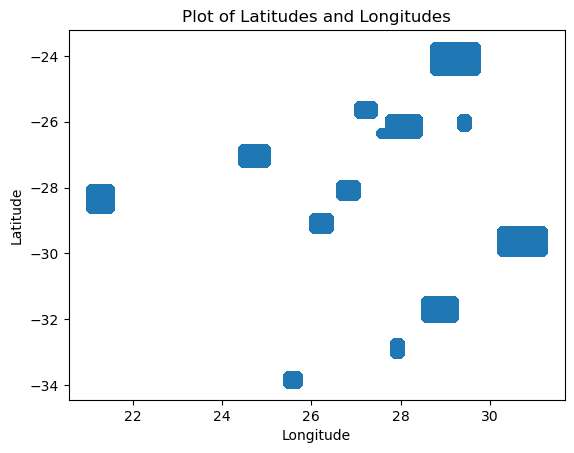

In [28]:

latitude = train['latitude']
longitude = train['longitude']


# Create a scatter plot
plt.scatter(longitude, latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Latitudes and Longitudes')
plt.show()
#the locations are different


In [29]:
def convert_types(df):
    # Convert data types to reduce memory
    for c in df:
        col_type = str(df[c].dtypes)
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        
        # Convert objects to category
        if col_type == 'object':
            df[c] = df[c].astype('category')
        
        # numerics
        elif col_type in numerics:
            c_min = df[c].min()
            c_max = df[c].max()
            if col_type[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[c] = df[c].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[c] = df[c].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[c] = df[c].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[c] = df[c].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[c] = df[c].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[c] = df[c].astype(np.float32)
                else:
                    df[c] = df[c].astype(np.float64)  
        
    return df

In [30]:
train = convert_types(train)
test = convert_types(test)

In [31]:
train.shape

(74005, 76)

In [32]:
test.shape

(28085, 75)

In [33]:
#we are going to check duplicates of the location since the rest can have duplicates
train.duplicated(subset=['ID_LAT_LON_YEAR_WEEK']).any()
test.duplicated(subset=['ID_LAT_LON_YEAR_WEEK']).any()
#no duplicates so we move to checking nulls


False

* Understanding correlation

In [34]:
#lets undestand the correlation
train.corr()['emission'].sort_values().head(40)
#we can drop features with negative correlation

Cloud_surface_albedo                                       -0.058965
UvAerosolIndex_sensor_altitude                             -0.044773
NitrogenDioxide_sensor_altitude                            -0.040691
UvAerosolLayerHeight_aerosol_optical_depth                 -0.040219
CarbonMonoxide_sensor_altitude                             -0.037621
UvAerosolLayerHeight_aerosol_pressure                      -0.032772
SulphurDioxide_SO2_column_number_density_amf               -0.031871
CarbonMonoxide_H2O_column_number_density                   -0.024830
UvAerosolLayerHeight_solar_zenith_angle                    -0.024698
NitrogenDioxide_tropopause_pressure                        -0.021195
UvAerosolIndex_sensor_zenith_angle                         -0.019609
Ozone_sensor_zenith_angle                                  -0.019437
Cloud_cloud_top_pressure                                   -0.018180
Cloud_cloud_base_pressure                                  -0.017595
NitrogenDioxide_stratospheric_NO2_

In [35]:
def process(train , test) :
    #join the datasets to preprocess
    data = pd.concat([train,test])
    data.latitude, data.longitude = round(data.latitude, 2), round(data.longitude, 2)
    #to reduce precision of the coordinates
    data['location'] = [str(x) + '_' + str(y) for x, y in zip(data.latitude, data.longitude)]
    data = data.sort_values(by = ['location', 'year', 'week_no'])
    angle_cols = [col for col in data.columns if 'angle' in col or 'altitude' in col or 'depth' in col or 'height' in col]
    #these columns have negative correlation and may not help us that much
    shift_cols = [col for col in data.columns if col not in angle_cols + ['ID_LAT_LON_YEAR_WEEK','year_week','longitude','latitude','emission','year_month','month','latitude','longitude' 'location','location','bin','year','week_no',]]    
    #to capture  capture underlying periodic patterns or relationships in the data that are not readily apparent in the original representation
    #to also reduce noise in variations
    def sin_transformer(period):
        return FunctionTransformer(lambda x: np.sin(x / period *2 * np.pi))

    def cos_transformer(period):
        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

    def periodic_spline_transformer(period, n_splines=None, degree=3):
        if n_splines is None:
            n_splines = period
        n_knots = n_splines + 1 # periodoc and include bias = True
        return SplineTransformer(degree=degree,
                                n_knots=n_knots,
                                knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
                                extrapolation="periodic",
                                include_bias=True)  
    #creating a month column from year and week number
   
    def getMonth(year: int, week: int) -> int:
        return datetime.datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w").month
    data['month'] = data.apply(lambda x: getMonth(x['year'], x['week_no']), axis=1)
    
    
        # Extract trigonometric features
    data["month_sin"] = sin_transformer(12).fit_transform(data["month"])
    data["month_cos"] = cos_transformer(12).fit_transform(data["month"])

 # Extract periodic spline-based features
    spline_cols_month = [f"cyclic_month_spline_{i}" for i in range(1, 7)]
    

    data[spline_cols_month] = periodic_spline_transformer(12, n_splines=6).fit_transform(np.array(data.month).reshape(-1,1))
    
    

    



 
    for col in shift_cols:
        data[f"{col}_rolling_mean_39"] = data[col].rolling(window=39).mean()
        data[f"{col}__rolling_max_39"] = data[col].rolling(window=39).max()
        data[f"{col}__rolling_min_39"] = data[col].rolling(window=39).min()
        data[f"{col}__rolling_sum_39"] = data[col].rolling(window=39).sum()
        data[f"{col}__rolling_std_39"] = data[col].rolling(window=39).std()
        data[f"{col}__rolling_skew_39"] = data[col].rolling(window=39).skew()
        
        data[f"{col}_rolling_mean_52"] = data[col].rolling(window=52).mean()
        data[f"{col}__rolling_max_52"] = data[col].rolling(window=52).max()
        data[f"{col}__rolling_min_52"] = data[col].rolling(window=52).min()
        data[f"{col}__rolling_sum_52"] = data[col].rolling(window=52).sum()
        data[f"{col}__rolling_std_52"] = data[col].rolling(window=52).std() 
        data[f"{col}__rolling_skew_52"] = data[col].rolling(window=52).skew() 
        data[f"{col}_rolling_mean"] = data[col].rolling(window=17).mean()
        data[f"{col}__rolling_max"] = data[col].rolling(window=17).max()
        data[f"{col}__rolling_min"] = data[col].rolling(window=17).min()
        data[f"{col}__rolling_sum"] = data[col].rolling(window=17).sum()
        data[f"{col}__rolling_std"] = data[col].rolling(window=17).std() 
        data[f"{col}__rolling_skew"] = data[col].rolling(window=17).skew() 




        
        data[f"{col}__location_mean"] = data.groupby(['location'])[col].transform('mean')
        data[f"{col}__location_std"] = data.groupby(['location'])[col].transform('std')
        data[f"{col}__location_min"] = data.groupby(['location'])[col].transform('min')
        data[f"{col}__location_max"] = data.groupby(['location'])[col].transform('max')
        data[f"{col}__location_skew"] = data.groupby(['location'])[col].transform('skew')
        

        
    for col in ['location']:
        data[col] = le.fit_transform(data[col])
        
    data = data.drop(columns = angle_cols + ['longitude','latitude'])
    train = data[data['ID_LAT_LON_YEAR_WEEK'].isin(train['ID_LAT_LON_YEAR_WEEK'].unique())]

    test = data[~data['ID_LAT_LON_YEAR_WEEK'].isin(train['ID_LAT_LON_YEAR_WEEK'].unique())]
    


    return train , test

In [36]:
train , test = process(train , test)

In [37]:
train.shape

(74005, 710)

In [38]:
train = train.sort_values(by = ['location','year','week_no'])
test = test.sort_values(by = ['location','year','week_no'])
train.head()

,ID_LAT_LON_YEAR_WEEK,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,...,Cloud_surface_albedo__rolling_max,Cloud_surface_albedo__rolling_min,Cloud_surface_albedo__rolling_sum,Cloud_surface_albedo__rolling_std,Cloud_surface_albedo__rolling_skew,Cloud_surface_albedo__location_mean,Cloud_surface_albedo__location_std,Cloud_surface_albedo__location_min,Cloud_surface_albedo__location_max,Cloud_surface_albedo__location_skew
0,ID_-23.73_28.77_2019_1,2019,1,0.000167,0.713379,0.000102,0.223877,0.000033,0.023407,2830.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.862793
1,ID_-23.73_28.77_2019_2,2019,2,-0.000155,0.812988,-0.000137,0.080261,-0.000067,0.024185,2136.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.862793
2,ID_-23.73_28.77_2019_3,2019,3,-0.000065,0.860352,-0.000062,0.161011,-0.000031,0.023697,1908.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.862793
3,ID_-23.73_28.77_2019_4,2019,4,0.000152,0.422363,0.000087,0.046509,0.000031,0.022354,2122.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.862793
4,ID_-23.73_28.77_2019_5,2019,5,0.000024,1.004883,0.000028,0.214233,0.000005,0.023041,1750.0,...,NaN,NaN,NaN,NaN,NaN,0.214902,0.053963,0.120361,0.462646,0.862793


In [39]:
train.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       ...
       'Cloud_surface_albedo__rolling_max',
       'Cloud_surface_albedo__rolling_min',
       'Cloud_surface_albedo__rolling_sum',
       'Cloud_surface_albedo__rolling_std',
       'Cloud_surface_albedo__rolling_skew',
       'Cloud_surface_albedo__location_mean',
       'Cloud_surface_albedo__location_std',
       'Cloud_surface_albedo__location_min',
       'Cloud_surface_albedo__location_max',
       'Cloud_surface_albedo__location_skew'],
      dtype='object', length=710)

* Filled the nulls with the mean in each column

In [40]:
columns_with_nulls = train.columns[train.isnull().sum() > 0]
for column in columns_with_nulls:
    column_mean = train[column].mean()
    train[column].fillna(column_mean, inplace=True)


In [41]:
columns_with_nulls = test.columns[test.isnull().sum() > 0]
for column in columns_with_nulls:
    column_mean = test[column].mean()
    test[column].fillna(column_mean, inplace=True)


In [42]:
train.isnull().any().sum()

35

# Model Building

In [43]:
# Selecting the independent variables and the target variable
from sklearn.model_selection import train_test_split
X = train.drop(['ID_LAT_LON_YEAR_WEEK','emission','location'], axis = 1)
y = train.emission

In [44]:
from sklearn.preprocessing import StandardScaler
fold_pred=[]
oof_pred = []



params1 = {'learning_rate': 0.2,
           'subsample': 0.9, 
           'colsample_bytree': 0.5, 
           'max_depth': 12,
           'objective':'rmse'}
        

fold= StratifiedKFold(n_splits=12)
i=1
for train_index, test_index in fold.split(X,X['month']):      
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = lgb.LGBMRegressor(**params1, n_estimators = 3050)

    model.fit(X_train,y_train,eval_set=[(X_test ,y_test)], early_stopping_rounds=120, verbose = 250)#erly100

    preds= model.predict(X_test,num_iteration=model.best_iteration_ )
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds), squared=False))
    p2 = model.predict(test[X.columns],num_iteration=model.best_iteration_)
    fold_pred.append(np.expm1(p2))
    
print(np.mean(oof_pred))

err:  2363.2740841768205
err:  1810.8895479757816
err:  3414.186119962502
err:  176105.28777222923
[250]	valid_0's rmse: 22843.5
[500]	valid_0's rmse: 22843.5
err:  10702.143217455288
err:  2864.421849889573
err:  1538.5515031147527
err:  7436.4170337543665
[250]	valid_0's rmse: 6216.57
err:  3890.25887867128
[250]	valid_0's rmse: 17627.2
err:  13160.396285747414
err:  1827.9404993926069
err:  8690.13595858566
19483.658562579607


In [45]:
X_train.shape

(67838, 707)

In [46]:
new_test = test.drop(['ID_LAT_LON_YEAR_WEEK','emission','location'], axis = 1)

In [47]:
new_test.shape

(28085, 707)

* Creating a dataframe of the predictions

In [48]:
preds = np.mean(fold_pred,axis=0)
subb_2 = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test['ID_LAT_LON_YEAR_WEEK'],
    'target': preds
})


subb_2.target.describe()

count    28085.000000
mean      3412.708123
std       3671.801802
min        296.386418
25%        900.392343
50%       2295.124932
75%       4382.297312
max      23061.661149
Name: target, dtype: float64

In [49]:
subb_2.to_csv('datathon11.csv',index=False)

Text(0.5, 1.0, 'lgbmRegressor features importance (top 10):')

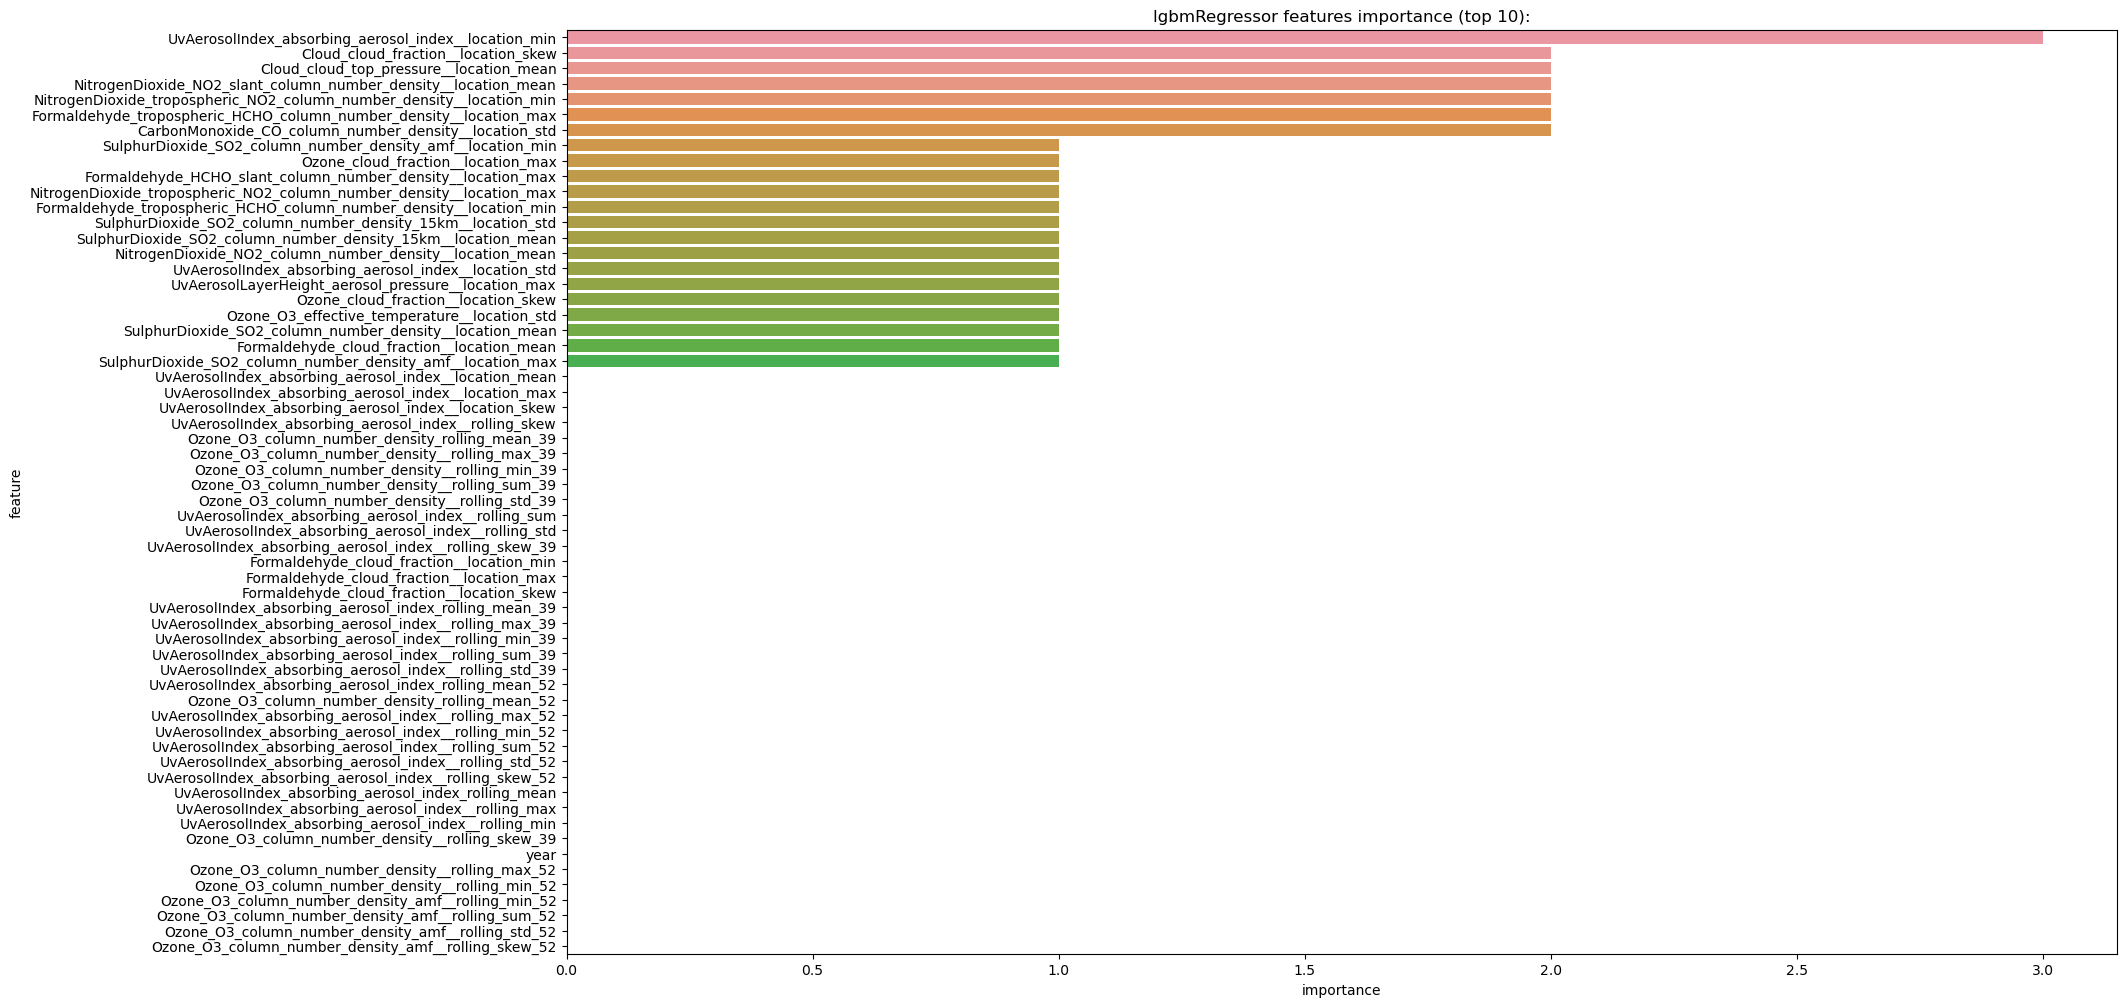

In [50]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('lgbmRegressor features importance (top 10):')

# xgb model

In [54]:
import xgboost as xgb

# Initialize an XGB model
xgb_model = xgb.XGBRegressor()

# Set the parameters
params = {'learning_rate': 0.2,      # Learning rate (controls the step size during boosting)
    'max_depth': 6,            # Maximum depth of each tree
    'subsample': 0.8,          # Subsample ratio of the training instances (randomly samples the training data)
    'colsample_bytree': 0.8,   # Subsample ratio of columns when constructing each tree
    
}

# Set the parameters in the model
xgb_model.set_params(**params)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [55]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [56]:
preds6= (xgb_model.predict(test[X.columns]))

In [57]:
preds.shape

(28085,)

In [58]:
# Ensemble the predictions using simple averaging
ensemble_predictions = (preds6+ preds) / 2


In [59]:
#preds = np.mean(fold_pred,axis=0)
subb_5 = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test['ID_LAT_LON_YEAR_WEEK'],
    'target': ensemble_predictions
})


In [60]:
subb_5.describe()

,target
count,28085.000000
mean,1710.084246
std,1836.165734
min,150.897424
25%,453.852009
50%,1151.184574
75%,2195.384216
max,11535.214065


In [61]:
subb_5.to_csv('datathon19.csv',index=False)

In [62]:
pred= model.predict(X_test,num_iteration=model.best_iteration_ )

In [63]:
xgb_predss=xgb_model.predict(X_test)

In [64]:
ensemble=(pred+xgb_predss)/2

In [65]:
# Calculate the mean squared error for each model
xgb_mse = mean_squared_error(y_test, xgb_predss)
lgbm_mse = mean_squared_error(y_test, pred)
ensemble_mse = mean_squared_error(y_test, ensemble)

print(f"XGBoost MSE: {xgb_mse}")
print(f"LightGBM MSE: {lgbm_mse}")
print(f"Ensemble MSE: {ensemble_mse}")

XGBoost MSE: 81395160.0
LightGBM MSE: 81384623.5346613
Ensemble MSE: 81389894.6918484


<h1 style="color:Maroon"> The End!!</h1>